In [48]:
import numpy as np
import pandas as pd
import os

# plotting 
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

# data manager and analysis
import vodex as vx
import numan as nu

# writing files
import tifffile as tif

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Project structure: 

Provide the project folder with the "processed" folder created in the previous notebook. 

As you keep going with the analysis, the folder will have the following structure: 

```
processed
│   experiment.json <----------------------------------- (DONE in 01) the file that contains everything about the experiment, you are creating it once and will be reusing ever after
│   experiment_dff.json <------------------------------- (DONE in 01) everything about the experiment, but loads from the dff movie, not from the raw data
└───dff_movie  <---------------------------------------- (DONE in 01) the dff movie :) 
│   │   dff_movie_0000.tif
│   │   dff_movie_0001.tif
│   │   ... 
└───tscore_volumes  <----------------------------------- (WILL BE DONE in this notebook) t-score tif files per pair
│   └───2v3
│       │   tscore_2v3.tif
│   └───3v5
│       │   tscore_3v5.tif
│   └───2v5
│       │   tscore_2v5.tif
│   └───2vB
│       │   tscore_2vB.tif
│   └───3vB
│       │   tscore_3vB.tif
│   └───5vB
│       │   tscore_5vB.tif
│   └───BvB1
│       │   tscore_BvB1.tif
│   └───BvB2
│       │   tscore_BvB2.tif
│   └───BvB3
│       │   tscore_BvB3.tif
└───diff_volumes  <------------------------------------- (WILL BE DONE in this notebook) absolute difference tif files per pair
│   └───2v3
│       │   diff_2v3.tif
│   └───3v5
│       │   diff_3v5.tif
│   └───...
└───spots
│   └───imaris  <--------------------------------------- ATTENTION : You need to put stuff generated by imaris into this folder!!! 
│       │   └───tscore_2v3_Statistics
│       │       │     tscore_2v3_Position.csv
│       │       │     tscore_2v3_Diameter.csv
│       │       │     ...
│       │   └───tscore_3v5_Statistics
│       │       │     tscore_3v5_Position.csv
│       │       │     tscore_3v5_Diameter.csv
│       │       │     ...
│       │   └───tscore_2v5_Statistics
│       │       │     ...
│       │   └───...
│   └───signals  <-------------------------------------- json files with the extracted signals, also will have the group info after you added it
│       │   spots_2v3.json
│       │   spots_3v5.json
│       │   spots_2v5.json
│       │     ...
│   └───reports  <---------------------------------- tiffs and pdf with the cells significant in any pairwise comparison
│       └───all_significant  <---------------------- tiffs and pdf with all significant cells per group
│           │   └───signals  <---------------------- pdfs with signals
│           │       │     ...
│           │   └───images <------------------------ tif masks 
│           │       │     ...
│       └───groupped  <----------------------------- tiffs and pdf where the cells are groupped based on signal shape .. or anything else you want
│           │   readme.txt  <----------------------- ATTENTION : you need to describe the groups
│           │   └───signals  <---------------------- pdfs with signals
│           │       │     ...
│           │   └───images  <----------------------- tif masks 
│           │       │     ...
```
# Set project folder
Also, if the processed folder should already exist if you created dff movies. If the folder doesn't exist, it will complain ...

In [3]:
project_folder = "D:/Code/repos/numan/notebooks/data/2vs3vs5/"
path = os.path.join(project_folder, 'processed')

assert os.path.isdir(path), "the directory 'processed' doesn't exist in the project," \
                                " did you forget to run the previous notebook?"

Set the processed directory as our working directory:

In [7]:
os.chdir(path)
os.getcwd()

'D:\\Code\\repos\\numan\\notebooks\\data\\2vs3vs5\\processed'

# Load experiment with the dff_movie as the data: 

In [8]:
experiment = vx.from_json(vx.Experiment, "experiment_dff.json")
experiment.summary()

Total of 115 files.
Check the order :
[ 0 ] dff_movie_0000.tif : 936 frames
[ 1 ] dff_movie_0001.tif : 572 frames
[ 2 ] dff_movie_0002.tif : 572 frames
[ 3 ] dff_movie_0003.tif : 572 frames
[ 4 ] dff_movie_0004.tif : 572 frames
[ 5 ] dff_movie_0005.tif : 572 frames
[ 6 ] dff_movie_0006.tif : 572 frames
[ 7 ] dff_movie_0007.tif : 572 frames
[ 8 ] dff_movie_0008.tif : 572 frames
[ 9 ] dff_movie_0009.tif : 572 frames
[ 10 ] dff_movie_0010.tif : 572 frames
[ 11 ] dff_movie_0011.tif : 572 frames
[ 12 ] dff_movie_0012.tif : 572 frames
[ 13 ] dff_movie_0013.tif : 572 frames
[ 14 ] dff_movie_0014.tif : 572 frames
[ 15 ] dff_movie_0015.tif : 572 frames
[ 16 ] dff_movie_0016.tif : 572 frames
[ 17 ] dff_movie_0017.tif : 572 frames
[ 18 ] dff_movie_0018.tif : 572 frames
[ 19 ] dff_movie_0019.tif : 572 frames
[ 20 ] dff_movie_0020.tif : 572 frames
[ 21 ] dff_movie_0021.tif : 572 frames
[ 22 ] dff_movie_0022.tif : 572 frames
[ 23 ] dff_movie_0023.tif : 572 frames
[ 24 ] dff_movie_0024.tif : 572 fram

# Create T-Score Image

## get the volumes corresponding to different conditions

In [10]:
def merge_idx(idx_list):
    return np.sort(np.concatenate(idx_list))

blank = vx.Condition(vx.Stimulus('blank','blank'))
dot2 = vx.Condition(vx.Stimulus('2dot','2dot'))
dot3 = vx.Condition(vx.Stimulus('3dot','3dot'))
dot5 = vx.Condition(vx.Stimulus('5dot','5dot'))

# indeces of the volumes to load
dot2_idx = experiment.select_volumes(dot2)
dot3_idx = experiment.select_volumes(dot3)
dot5_idx = experiment.select_volumes(dot5)
# as blank, we will take the volumes right before the signals 
blank_idx = merge_idx([(dot2_idx-1), (dot3_idx-1), (dot5_idx-1)])

print(f"We found:\n", 
      f"{dot2_idx.shape} volumes with 2dot")
print(f" {dot3_idx.shape} volumes with 3dot")
print(f" {dot5_idx.shape} volumes with 5dot")
print(f" {blank_idx.shape} volumes with blank")

We found:
 (54,) volumes with 2dot
 (54,) volumes with 3dot
 (54,) volumes with 5dot
 (162,) volumes with blank


If you can't fit all the volumes at once, do by pair, or even in chunks ( not implemented yet, but will be ) 

In [37]:
# load the volumes 
dot2_volumes = experiment.volume_manager.load_volumes(dot2_idx, verbose = False)
dot3_volumes = experiment.volume_manager.load_volumes(dot3_idx, verbose = False)
dot5_volumes = experiment.volume_manager.load_volumes(dot5_idx, verbose = False)
blank_volumes = experiment.volume_manager.load_volumes(blank_idx, verbose = False)
T,Z,Y,X = dot2_volumes.shape
print( f"Volumes shape:\nZ : {Z}\nY : {Y}\nX : {X}")

100%|████████████████████████████████████████████████████████████████████████████| 8424/8424 [00:06<00:00, 1400.72it/s]


Volumes shape:
Z : 52
Y : 468
X : 500


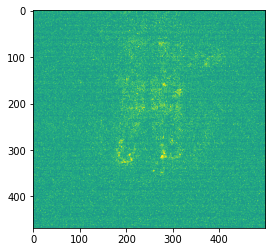

In [26]:
# check a random slice of a volume, make sure it looks as expected ... 
plt.imshow(dot2_volumes[5,25,:,:],vmin = -100,vmax = 100)

## calculate and write t-score and diff images 
Create the folders to put images in: 

In [27]:
os.makedirs('tscore_volumes')
os.makedirs('diff_volumes')

get a wrapper functins : 



In [44]:
# multiply difference image and t-score image by this constants before turning into integer and writing... 
T_SCALE = 1000
DIFF_SCALE = 100 

def make_tscore(volumes1, volumes2, group_tag):
    """
    Creates and writes to dist a tscore image, based on the volumes pair provided. 
    """
    os.makedirs(f"tscore_volumes/{tag}")
    t_img = nu.get_t_score(volumes1, volumes2, absolute = True)*T_SCALE
    tif.imwrite(f'tscore_volumes/{group_tag}/tscore_{group_tag}.tif',
                t_img.astype(np.uint16),shape=(Z,Y,X),
                metadata={'spacing': RESOLUTION[0], 'unit': 'um','axes': 'ZYX'},
                resolution=(1/RESOLUTION[1], 1/RESOLUTION[2]),
                imagej=True)
    print(f'max t-image value : {t_img.max()}')
    
def make_diff(volumes1, volumes2, group_tag):
    """
    Creates and writes to dist a tscore image, based on the volumes pair provided. 
    """
    os.makedirs(f"diff_volumes/{tag}")
    diff = nu.get_diff(volumes1, volumes2, absolute = True)*DIFF_SCALE
    tif.imwrite(f'diff_volumes/{group_tag}/diff_{group_tag}.tif',
                diff.astype(np.uint16),shape=(Z,Y,X),
                metadata={'spacing': RESOLUTION[0], 'unit': 'um','axes': 'ZYX'},
                resolution=(1/RESOLUTION[1], 1/RESOLUTION[2]),
                imagej=True)
    print(f'diff image : {diff.max()}')


### 1. Write tscore and diff images for stimuli and stmuli vs blanks:

In [46]:
tag = "2v5"
print(f'{tag}_________________________________')
vol1 = dot2_volumes
vol2 = dot5_volumes
make_tscore(vol1, vol2, tag)
make_diff(vol1, vol2, tag)

tag = "2v3"
print(f'{tag}_________________________________')
vol1 = dot2_volumes
vol2 = dot3_volumes
make_tscore(vol1, vol2, tag)
make_diff(vol1, vol2, tag)

tag = "3v5"
print(f'{tag}_________________________________')
vol1 = dot3_volumes
vol2 = dot5_volumes
make_tscore(vol1, vol2, tag)
make_diff(vol1, vol2, tag)

tag = "2vB"
print(f'{tag}_________________________________')
vol1 = blank_volumes
vol2 = dot2_volumes
make_tscore(vol1, vol2, tag)
make_diff(vol1, vol2, tag)

tag = "3vB"
print(f'{tag}_________________________________')
vol1 = blank_volumes
vol2 = dot3_volumes
make_tscore(vol1, vol2, tag)
make_diff(vol1, vol2, tag)

tag = "5vB"
print(f'{tag}_________________________________')
vol1 = blank_volumes
vol2 = dot5_volumes
make_tscore(vol1, vol2, tag)
make_diff(vol1, vol2, tag)


2v5_________________________________
max t-image value : 1143.2918723918642
diff image : 19562.962962962964
2v3_________________________________
max t-image value : 1187.2951663435374
diff image : 19551.851851851854
3v5_________________________________
max t-image value : 1092.9853999183622
diff image : 4100.0
2vB_________________________________
max t-image value : 1288.5535135627297
diff image : 19935.802469135804
3vB_________________________________
max t-image value : 885.1137515447447
diff image : 3948.7654320987654
5vB_________________________________
max t-image value : 937.5331996658667
diff image : 3750.617283950618


### 4. t-score images and diff images for random shuffle of blanks 

In [51]:
np.random.seed(42)

n_blanks = blank_volumes.shape[0]
n_stim = dot2_volumes.shape[0]

assert n_stim*2 < n_blanks, "there should be more blank volumes, something went wrong ..."

split_idx = {}
for isplit in [1,2,3]:
    
    tag = f"BvB{isplit}"
    print(f'{tag}_________________________________')
    
    random_set = np.random.choice(n_blanks, size=n_stim*2, replace=False)
    split_idx[f'split{isplit} group1'] = random_set[0:n_stim]
    split_idx[f'split{isplit} group2'] = random_set[n_stim:n_stim*2]
    
    vol1 = blank_volumes[split_idx[f'split{isplit} group1'],:,:,:]
    vol2 = blank_volumes[split_idx[f'split{isplit} group2'],:,:,:]
    
    make_tscore(vol1, vol2, tag)
    make_diff(vol1, vol2, tag)

split_df = pd.DataFrame.from_dict(split_idx)
split_df.to_csv('tscore_volumes/BvB_split_info.csv',index=False)
split_df.to_csv('diff_volumes/BvB_split_info.csv',index=False)    

BvB1_________________________________
max t-image value : 1091.0032026716153
diff image : 4879.6296296296305
BvB2_________________________________
max t-image value : 1119.2350966909464
diff image : 6066.666666666667
BvB3_________________________________
max t-image value : 1152.616881220713
diff image : 5629.629629629629


# Now segment the t-score images and add to the project!

You can use any way to segemnt them, we found that using Imaris works really well! 
If you use Imaris, **put hte files that it prodices into processed/spots/imaris**, see the schematics below, We will only need position and diameter, but you can dump all of them there ...


```
processed
│   
└───spots
│   └───imaris  <--------------------------------------- ATTENTION : You need to put stuff generated by imaris into this folder!!! 
│       │   └───tscore_2v3_Statistics
│       │       │     tscore_2v3_Position.csv
│       │       │     tscore_2v3_Diameter.csv
│       │       │     ...
│       │   └───tscore_3v5_Statistics
│       │       │     tscore_3v5_Position.csv
│       │       │     tscore_3v5_Diameter.csv
│       │       │     ...
│       │   └───tscore_2v5_Statistics
│       │       │     ...
│       │   └───...
└───...  
```
The following cell will cerate the folder to put the files into : 

In [52]:
path = os.path.join(path, 'spots', 'imaris')
os.makedirs(path)